In [2]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [3]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [4]:
llna = pd.read_csv(raw_dir/'llna_cleaned.csv', index_col = [0])

In [5]:
llna

,DTXSID,CASRN,SMILES,reaction_chemistry_domain,LLNA,DPRA,KeratinoSens,hCLAT,rxn
0,DTXSID1031626,1896-62-4,CC(=O)\C=C\C1=CC=CC=C1,MA,1,1.0,1,1.0,MA
1,DTXSID4051879,2277-19-2,CC\C=C/CCCCC=O,SB,1,0.0,1,NaN,SB
2,DTXSID00231670,82297-64-1,CCC(=O)\C=C\C1=CC=C(OC)C=C1,MA,1,1.0,1,NaN,MA
3,DTXSID7049398,116-26-7,CC1=C(C=O)C(C)(C)CC=C1,MA,1,1.0,1,NaN,MA
4,DTXSID7026235,552-30-7,OC(=O)C1=CC=C2C(=O)OC(=O)C2=C1,Acyl,1,1.0,0,1.0,Acyl
...,...,...,...,...,...,...,...,...,...
217,DTXSID1041425,6728-26-3,CCC\C=C\C=O,MA,1,1.0,1,1.0,MA
218,DTXSID8049416,533-75-5,OC1=CC=CC=CC1=O,MA_or_SN1,1,NaN,NaN,1.0,MA_or_SN1
219,DTXSID3037757,112-45-8,C=CCCCCCCCCC=O,SB,1,NaN,NaN,0.0,SB
220,DTXSID0021969,121-33-5,COC1=C(O)C=CC(C=O)=C1,non-reactive_,0,0.0,0,0.0,non-reactive


In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import networkx as nx

MOLS = dict(zip(llna['DTXSID'], llna['SMILES']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,2048)) for i in MOLS.values()])
FP0.index = MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]

In [9]:
from rdkit.Chem import rdMMPA

In [59]:
def fragment_molecule(mol):
    return list(rdMMPA.FragmentMol(mol, resultsAsMols=False))

In [16]:
llna = (llna
 .assign(mol_obj = lambda df: df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)))
 .assign(fragments = lambda df: df['mol_obj'].apply(lambda x: fragment_molecule(x)))
)

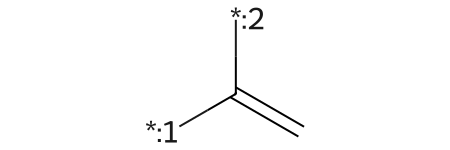

In [30]:
fragment_molecule(MOLS['DTXSID8021438'])[1][0]

In [37]:
(llna
 .rename(columns = {'DTXSID':'id', 'SMILES':'smiles'})
 .loc[:,['smiles','id']]
 .to_csv(raw_dir/'input_mmdb.csv',header=False,index=False, sep = '\t' )
)

In [150]:
llna['rxn']

0                MA
1                SB
2                MA
3                MA
4              Acyl
           ...     
217              MA
218       MA_or_SN1
219              SB
220    non-reactive
221    non-reactive
Name: rxn, Length: 222, dtype: object

In [60]:
fragment_molecule(Chem.MolFromSmiles('CCCCCCCC'))

[('', 'CCCCCCC[*:1].C[*:1]'),
 ('C([*:1])[*:2]', 'CCCCCC[*:2].C[*:1]'),
 ('C(C[*:2])[*:1]', 'CCCCC[*:2].C[*:1]'),
 ('C(C[*:1])C[*:2]', 'CCCC[*:2].C[*:1]'),
 ('C(CC[*:2])C[*:1]', 'CCC[*:2].C[*:1]'),
 ('C(CC[*:1])CC[*:2]', 'CC[*:2].C[*:1]'),
 ('C(CCC[*:2])CC[*:1]', 'C[*:1].C[*:2]'),
 ('', 'CCCCCC[*:1].CC[*:1]'),
 ('C([*:1])[*:2]', 'CCCCC[*:2].CC[*:1]'),
 ('C(C[*:2])[*:1]', 'CCCC[*:2].CC[*:1]'),
 ('C(C[*:1])C[*:2]', 'CCC[*:2].CC[*:1]'),
 ('C(CC[*:2])C[*:1]', 'CC[*:1].CC[*:2]'),
 ('', 'CCCCC[*:1].CCC[*:1]'),
 ('C([*:1])[*:2]', 'CCCC[*:2].CCC[*:1]'),
 ('C(C[*:2])[*:1]', 'CCC[*:1].CCC[*:2]'),
 ('', 'CCCC[*:1].CCCC[*:1]')]

In [63]:
import sqlite3

# Connect to the database
connection = sqlite3.connect(raw_dir/"input.mmpdb")
cursor = connection.cursor()

# Query sqlite_master to list table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the table names
for table in tables:
    print(table[0])



dataset
compound
property_name
compound_property
rule_smiles
rule
rule_environment
environment_fingerprint
pair
constant_smiles
rule_environment_statistics
sqlite_stat1


In [73]:
cursor.execute('select * from rule_smiles')
cursor.fetchone()

(0, '[*:1]CCC', 3)

In [81]:
mmps = pd.read_csv(raw_dir/'analysed.csv', header=None ,sep = '\t')

In [106]:
mmps.columns = ['P1_smiles', 'P2_smiles', 'P1_ID', 'P2_ID', 'Variable_SMIRK','Constant']

In [107]:
mmps

,P1_smiles,P2_smiles,P1_ID,P2_ID,Variable_SMIRK,Constant
0,CCC\C=C\C=O,CCCCCCC\C=C\C=O,DTXSID1041425,DTXSID5047035,[*:1]CCC>>[*:1]CCCCCCC,[*:1]/C=C\C=O
1,CCCCBr,CCCCCCBr,DTXSID6021903,DTXSID4021929,[*:1]CCCC>>[*:1]CCCCCC,[*:1]Br
2,CCCCBr,[O-][N+](=O)C1=CC=C(CBr)C=C1,DTXSID6021903,DTXSID7049392,[*:1]CCCC>>[*:1]Cc1ccc([N+](=O)[O-])cc1,[*:1]Br
3,CCCCBr,BrCC1=CC=CC=C1,DTXSID6021903,DTXSID8024658,[*:1]CCCC>>[*:1]Cc1ccccc1,[*:1]Br
4,COC(=O)CCBr,CCCCBr,DTXSID6063010,DTXSID6021903,[*:1]CCC(=O)OC>>[*:1]CCCC,[*:1]Br
...,...,...,...,...,...,...
8383,OC1=C(C=CC=C1)C(=O)OCC1=CC=CC=C1,OC1=CC=CC=C1,DTXSID1024598,DTXSID5021124,[*:1]C(=O)OCc1ccccc1>>[*:1][H],[*:1]c1ccccc1O
8384,OC(=O)C1=C(O)C=CC=C1,COC(=O)C1=C(O)C=CC=C1,DTXSID7026368,DTXSID5025659,[*:1]C(=O)O>>[*:1]C(=O)OC,[*:1]c1ccccc1O
8385,COC(=O)C1=C(O)C=CC=C1,OC1=CC=CC=C1,DTXSID5025659,DTXSID5021124,[*:1]C(=O)OC>>[*:1][H],[*:1]c1ccccc1O
8386,OC(=O)C1=C(O)C=CC=C1,OC1=CC=CC=C1,DTXSID7026368,DTXSID5021124,[*:1]C(=O)O>>[*:1][H],[*:1]c1ccccc1O


In [108]:
grouped = mmps.groupby('Constant')  # Group by the "core" column
for core, group in grouped:
    print(f"Core: {core}")
    print(group[['P1_ID' 	,'P2_ID']])
    break

Core: [*:1]/C=C\C=O
           P1_ID          P2_ID
0  DTXSID1041425  DTXSID5047035


In [110]:
mmps['Constant'].nunique()

249

In [111]:
cores = mmps['Constant'].unique()  # Extract unique cores


# Create a DataFrame to store the SMARTS patterns
cores_df = pd.DataFrame({'Core_SMILES': cores})

In [112]:
cores_df['Core_SMILES'].tolist()[0]

'[*:1]/C=C\\C=O'

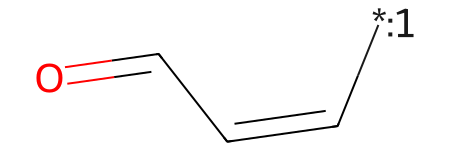

In [114]:
Chem.MolFromSmarts('[*:1]/C=C\\C=O')

In [121]:
def find_matching_cores(query_smiles, cores_df):
    query_mol = Chem.MolFromSmiles(query_smiles)
    matching_cores = []
    
    for _, row in cores_df.iterrows():
        core_mol = Chem.MolFromSmarts(row['Core_SMILES'])
       
        if query_mol.HasSubstructMatch(core_mol):
            matching_cores.append(row['Core_SMILES'])  # Store the original SMILES for reference
    
    return matching_cores


In [122]:
query_smiles = "CCCCBr"
matching_cores = find_matching_cores(query_smiles, cores_df)
print("Matching Cores:", matching_cores)

Matching Cores: ['[*:1]Br', '[*:1]C', '[*:1]C.[*:2]C', '[*:1]CBr', '[*:1]CC', '[*:1]CCC', '[*:1]CCCC']


In [7]:
rxn_domains = {k: group['DTXSID'].tolist() for k, group in llna.groupby('rxn') if len(group['DTXSID'].tolist()) >5}

In [8]:
import karateclub
from sklearn.manifold import TSNE

In [9]:
def mol_embed(m, g):
    m.fit(g)
    X_embedding = m.get_embedding()
    tsne = TSNE(n_components=2,random_state=42)
    z = tsne.fit_transform(np.array(X_embedding))
    return z, X_embedding

In [10]:
def smile_to_mol_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    g = nx.Graph()
    
    # Add nodes with atom properties
    for atom in mol.GetAtoms():
        node_label = {
    "symbol": atom.GetSymbol(),
    "degree": atom.GetDegree(),
    "hybridization": str(atom.GetHybridization()),
    "aromaticity": atom.GetIsAromatic(),
    "formal_charge": atom.GetFormalCharge(),
    "implicit_hydrogen_count": atom.GetTotalNumHs()
}
        g.add_node(atom.GetIdx(), feature = node_label)

    # Add edges with bond properties
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=str(bond.GetBondType()))

    return g

In [11]:
graphs = {k:smile_to_mol_graph(v) for k,v in zip(llna['DTXSID'], llna['SMILES'])}

In [12]:
graphs['DTXSID1031626']

In [13]:
model_dict = {'ldp': karateclub.LDP(), 'gl2': karateclub.GL2Vec(), 'graph2vec':karateclub.Graph2Vec(attributed=True)}

In [14]:
results = {}
for k,v  in model_dict.items():
    results[k] = mol_embed(v, list(graphs.values()))

In [15]:
from sklearn.preprocessing import minmax_scale,StandardScaler
from scipy.spatial.distance import pdist,squareform

In [16]:
scaler = StandardScaler()

In [17]:
g2v = pd.DataFrame(scaler.fit_transform(results['graph2vec'][1]), index = graphs.keys())

<Axes: >

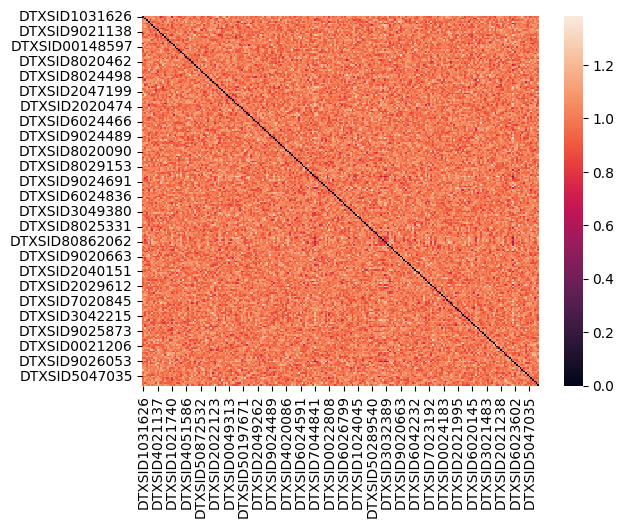

In [18]:
sns.heatmap(pd.DataFrame(squareform(pdist(g2v, 'cosine')), index = graphs.keys(), columns = graphs.keys()))

<Axes: >

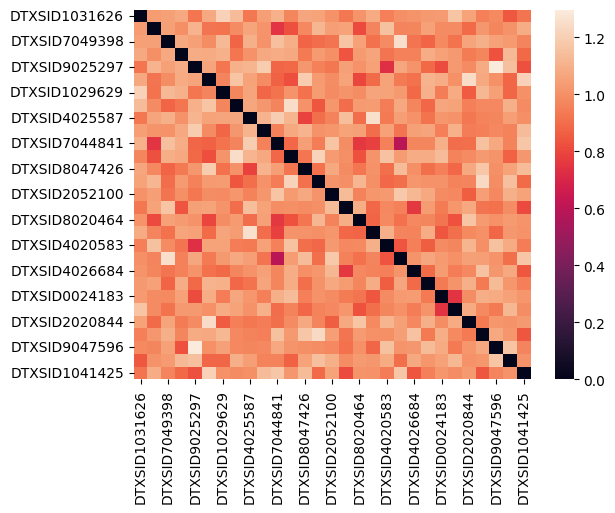

In [19]:
sns.heatmap(pd.DataFrame(squareform(pdist(g2v, 'cosine')), index = graphs.keys(), columns = graphs.keys()).loc[rxn_domains['MA'], rxn_domains['MA']])

In [20]:
mydfs = []
for k, v in results.items():
    df = pd.DataFrame(v[0], columns = ['comp_1', 'comp_2'])
    df['approach'] = k
    df = pd.concat([df,llna[['DTXSID','rxn']]], axis =1)
    df.columns = ['comp_1', 'comp_2','approach','DTXSID', 'rxn']
    
    mydfs.append(df)

In [21]:
#aggregated

In [22]:
aggregated = mydfs[2]['rxn'].value_counts().copy()
misc = aggregated[aggregated <10].reset_index(name = 'count')['rxn'].tolist()
mydfs[2]['new_group'] = mydfs[2]['rxn'].apply(lambda x: 'misc' if x in misc else x)

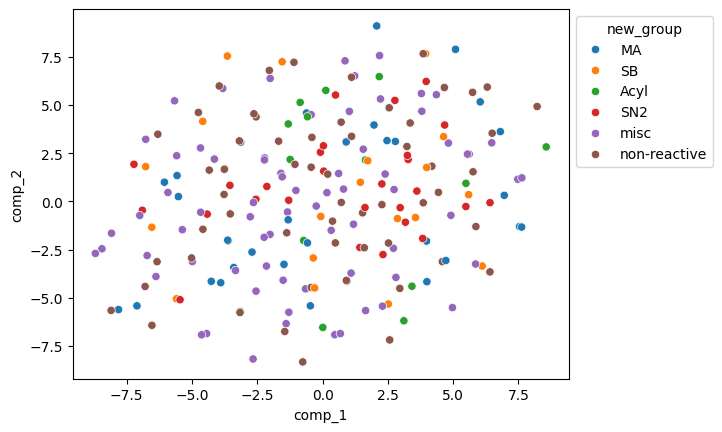

In [23]:
f, ax = plt.subplots()
ax = sns.scatterplot(data = mydfs[2], x = 'comp_1', y = 'comp_2', hue = 'new_group')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
f.savefig(figures_dir/'tsne_llna_graph2vec.png', dpi = 300,bbox_inches='tight')

In [630]:
times1 = pd.read_csv(raw_dir/'times1.csv', index_col = [0])

In [631]:
times1 = (times1
.assign(predecessor_id = lambda df_: pd.to_numeric(times1['Predecessor_ID'], errors = 'coerce').fillna(0).astype(int))

)

In [632]:
transformation_types = times1['transformation'].unique().tolist()
transformation_types = transformation_types[1:]

In [633]:
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024))
    else:
        return None

In [634]:
edges = times1[times1['Predecessor_ID'] != '-']

In [635]:
times1['Fingerprint'] = times1['SMILES'].apply(generate_fingerprint)

[15:46:02] SMILES Parse Error: syntax error while parsing: CCCCCCCCCCCCOC(=O)c1cc([O.])c(O)c(O)c1
[15:46:02] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCCCCCCOC(=O)c1cc([O.])c(O)c(O)c1' for input: 'CCCCCCCCCCCCOC(=O)c1cc([O.])c(O)c(O)c1'
[15:46:04] SMILES Parse Error: syntax error while parsing: CCCOC(=O)c1cc([O.])c(O)c(O)c1
[15:46:04] SMILES Parse Error: Failed parsing SMILES 'CCCOC(=O)c1cc([O.])c(O)c(O)c1' for input: 'CCCOC(=O)c1cc([O.])c(O)c(O)c1'
[15:46:04] SMILES Parse Error: syntax error while parsing: Cc1ccc(S(=O)(=O)[N-](.[Na+])Cl)cc1
[15:46:04] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(S(=O)(=O)[N-](.[Na+])Cl)cc1' for input: 'Cc1ccc(S(=O)(=O)[N-](.[Na+])Cl)cc1'
[15:46:04] SMILES Parse Error: syntax error while parsing: Cc1ccc(S([N.])(=O)=O)cc1
[15:46:04] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(S([N.])(=O)=O)cc1' for input: 'Cc1ccc(S([N.])(=O)=O)cc1'
[15:46:04] SMILES Parse Error: syntax error while parsing: [O.]c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl
[15:46:04] SMIL

In [636]:
times1[times1['predecessor_id'] ==0]['Predecessor_ID'].unique()

array(['-'], dtype=object)

In [637]:
times1['ID_of_metabolite'].values

array([1, 2, 3, ..., 4, 7, 8])

In [638]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [639]:
transformation_index = {t: i for i, t in enumerate(transformation_types)}

In [640]:
n_transformations = len(transformation_types)

In [641]:
def create_node_label(row):
    # Concatenate the desired columns for more expressive labels
    return f"ID: {row['ID']}"

In [660]:
import hashlib

def encode_fingerprint(fingerprint):
    # Convert fingerprint to a hash-based label
    return hashlib.md5(fingerprint.encode()).hexdigest()


In [678]:
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        fingerprint = row['Fingerprint']
        if fingerprint is None:
            fingerprint_str = ""  # Fallback to an empty string (or define your default behavior)
        else:
            fingerprint_str = ''.join(map(str, fingerprint))
        #label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            label=encode_fingerprint(fingerprint_str),  # Encoded fingerprint as symbolic label
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            feature = fingerprint_str ,
            
        )
    
    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['predecessor_id'] != 0:  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['predecessor_id'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    # Store the graph with the Parent as the key
    graph_dict[parent] = G

In [679]:
graph_dict['DTXSID00148597']

In [680]:
for i, graph  in graph_dict.items():
    for node, data in graph.nodes(data = True):
        assert "feature" in data, f"Node {node}, graph {i} is missing the 'label' attribute"

In [681]:
for node, attrs in graph_dict['DTXSID0048189'].nodes(data = True):
    if not attrs:
        print(f"Empty node found: {node}")

In [682]:
for node, data in graph_dict["DTXSID0048189"].nodes(data=True):
    print(data)

{'label': 'ba339ef57a6e9e9bf8cfcd4b31d1927c', 'chemical_name': 'DTXSID0048189', 'SMILES': 'CCCCCCCCCCCCOC(=O)c1cc(O)c(O)c(O)c1', 'feature': '0000000000000100000000000000000001000000000000000000000001000000000000000000000010001000000000000000000010000000000000010000010000000000000000000101000000000000000000000000000000000000000000000000000000100000000000000000000001000000000000000000000000000000000000000000000000000000000000000000011000000001000000000000000000000000000000000000000000000000000010000100000000000000000000000000000000000000000000000000000000001000000000000000000000000000000100000000000100000000000000000000000000000000001000000000000000000000010000000000000000000000000000000000000000000000100000000011000100000001000000000000000000000000000000000000000000001000001000000010000000000000000000000000000000000000000000010000000000000010000000000000000000000000000100000000000000000000000000000000000000000000100000000010000000000001000000001000000000000000000000000000000001000000000

In [683]:
for i, graph in graph_dict.items():
    for node, data in list(graph.nodes(data=True)):  # Convert to list to modify the graph during iteration
        if "feature" not in data:
            print(f"Node {node}, graph {i} is missing the 'label' attribute. Removing node.")
            #graph.remove_node(node)  # Remove the node

In [684]:
for i, graph in graph_dict.items():
    for node, data in graph.nodes(data=True):
        if "feature" not in data or data["feature"] is None:
            graph.nodes[node]["feature"] = "default" 

In [685]:
from karateclub import Graph2Vec

In [686]:
for parent, graph in graph_dict.items():
    mapping = {node: idx for idx, node in enumerate(graph.nodes())}
    graph_dict[parent] = nx.relabel_nodes(graph, mapping)

In [687]:
#print(times2[times2['ID_of_metabolite'] == 1])

In [688]:
for parent, graph in graph_dict.items():
    assert all(isinstance(node, int) for node in graph.nodes()), f"Non-numeric indices found in graph {parent}"

In [689]:
for i, graph in graph_dict.items():
    for node, data in graph.nodes(data=True):
        if "feature" not in data:
            graph.nodes[node]["feature"] = "default"  # Ensure label exists
        if graph.degree(node) == 0:  # Check if node has no neighbors
            graph.add_edge(node, node)  

In [690]:
model = Graph2Vec(dimensions=128, wl_iterations=2, attributed = True)

# Fit the model on the list of graphs
model.fit(list(graph_dict.values()))

# Get embeddings
embeddings = model.get_embedding()

In [691]:
#pd.DataFrame(embeddings).describe()

<Axes: >

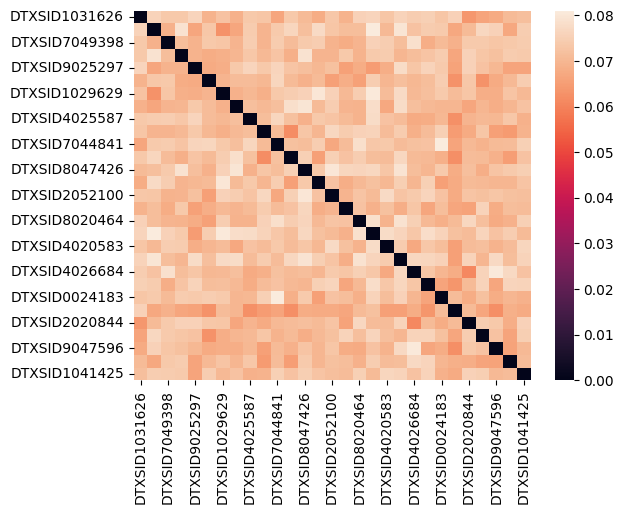

In [696]:
sns.heatmap(pd.DataFrame(squareform(pdist(pd.DataFrame(embeddings, index = graph_dict.keys())), 'euclidean'), index=graph_dict.keys(), columns = graph_dict.keys()).loc[rxn_domains['MA'], rxn_domains['MA']])

<Axes: >

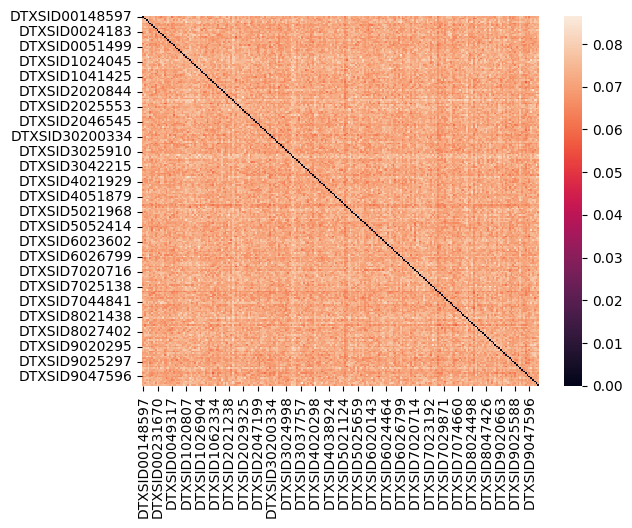

In [695]:
sns.heatmap(pd.DataFrame(squareform(pdist(pd.DataFrame(embeddings, index = graph_dict.keys())), 'euclidean'), index=graph_dict.keys(), columns = graph_dict.keys()))